In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\azazb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azazb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azazb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\azazb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
data = pd.read_csv("output.csv", encoding="ISO-8859-1")
data.head(7)

,id,app_id,content,author_id,is_positive
0,181331361,100.0,At least its a counter strike -1/100,7.656120e+16,Negative
1,180872601,100.0,Uh... So far my playthrough has not been great...,7.656120e+16,Negative
2,177836246,100.0,Better mechanics than cs2,7.656120e+16,Negative
3,177287444,100.0,buggy mess and NOT fun to play at all,7.656120e+16,Negative
4,176678990,100.0,"Whoever came up with this, is gonna fucking ge...",7.656120e+16,Negative
5,176118004,100.0,Every enemy and their grandmother have aimbot ...,7.656120e+16,Negative
6,172896379,100.0,l,7.656120e+16,Negative


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201202 entries, 0 to 201201
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           201202 non-null  object 
 1   app_id       201153 non-null  float64
 2   content      200725 non-null  object 
 3   author_id    201149 non-null  float64
 4   is_positive  201149 non-null  object 
dtypes: float64(2), object(3)
memory usage: 7.7+ MB


In [6]:
data.shape

(201202, 5)

In [5]:
# calculate the current class distribution
original_distribution = data['is_positive'].value_counts(normalize=True)

# select 10000 samples while maintaining the same class distribution
sampled_data = data.groupby('is_positive', group_keys=False).apply(
    lambda x: x.sample(n=int(10000 * original_distribution[x.name]), random_state=42)
)

# reset the index of the sampled dataset
sampled_data = sampled_data.reset_index(drop=True)

# verify the new shape
print("Original shape:", data.shape)
print("Sampled shape:", sampled_data.shape)

# verify the class distribution is maintained
print("\nOriginal class distribution:")
print(data['is_positive'].value_counts(normalize=True))
print("\nSampled class distribution:")
print(sampled_data['is_positive'].value_counts(normalize=True))

Original shape: (201202, 5)
Sampled shape: (9999, 5)

Original class distribution:
is_positive
Positive    0.510368
Negative    0.489632
Name: proportion, dtype: float64

Sampled class distribution:
is_positive
Positive    0.510351
Negative    0.489649
Name: proportion, dtype: float64


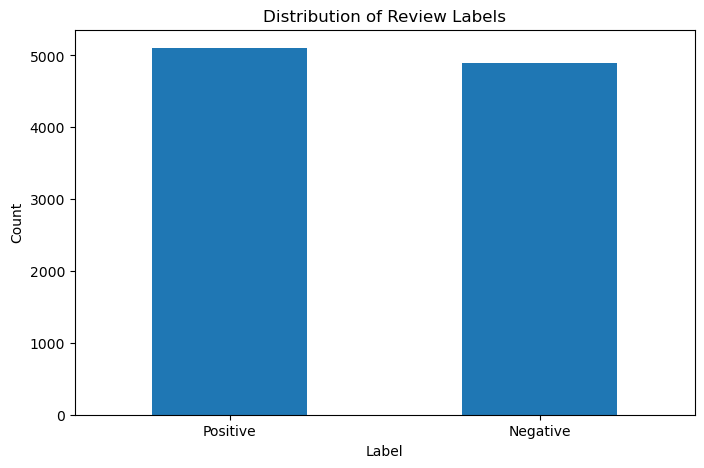

In [6]:
# Bar Plot
plt.figure(figsize=(8, 5))
sampled_data['is_positive'].value_counts().plot(kind='bar')
plt.title('Distribution of Review Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

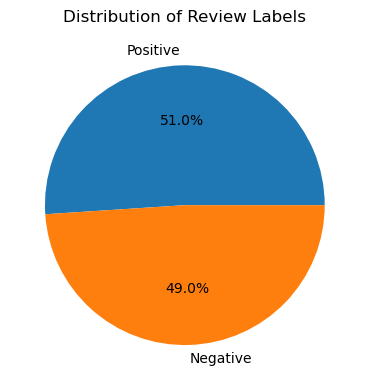

In [7]:
# pie Chart
plt.figure(figsize=(7, 4))
sampled_data['is_positive'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Review Labels')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [8]:
def preprocess_text(text):
    # convert to lowercase
    text = str(text).lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # join tokens back into text
    return ' '.join(tokens)

# applying preprocessing to the 'content' column
sampled_data['cleaned_content'] = sampled_data['content'].apply(preprocess_text)

In [9]:
# displaying a few examples of original and cleaned text
print("Original vs Cleaned Text Examples:")
for i in range(3):
    print("\nOriginal:", sampled_data['content'].iloc[i])
    print("Cleaned:", sampled_data['cleaned_content'].iloc[i])

Original vs Cleaned Text Examples:

Original: A reminder of how crappy games were 10 years ago
Cleaned: reminder crappy game year ago

Original: I really like this game its cool
Cleaned: really like game cool

Original: blue shift? more like bull shit

hl1 is great, hl:of is great, hl:bs is meh

it's not bad but it also ain't that good
you could probably skip this one and not miss out on anything special
Cleaned: blue shift like bull shit hl great hlof great hlbs meh bad also aint good could probably skip one miss anything special


In [10]:
sampled_data.head(7)

,id,app_id,content,author_id,is_positive,cleaned_content
0,9925216,220.0,A reminder of how crappy games were 10 years ago,7.656120e+16,Negative,reminder crappy game year ago
1,120402387,220.0,I really like this game its cool,7.656120e+16,Negative,really like game cool
2,14801220,130.0,blue shift? more like bull shit\n\nhl1 is grea...,7.656120e+16,Negative,blue shift like bull shit hl great hlof great ...
3,179268339,570.0,garbage,7.656120e+16,Negative,garbage
4,152310822,570.0,trash game !!!,7.656120e+16,Negative,trash game
5,9402482,280.0,I like Half Life. It is one of my all time fav...,7.656120e+16,Negative,like half life one time favourite fps game bel...
6,129581512,570.0,sdgsg,7.656120e+16,Negative,sdgsg


In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(sampled_data['cleaned_content'])

In [12]:
X_tfidf.shape


(9999, 5000)

In [13]:
y = (sampled_data['is_positive'] == 'Positive').astype(int)

In [14]:
X_tfidf_train, X_tfidf_test, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [17]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name} with {vectorizer_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} ({vectorizer_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Random Forest with TF-IDF
Accuracy: 78.85%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       992
           1       0.76      0.84      0.80      1008

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



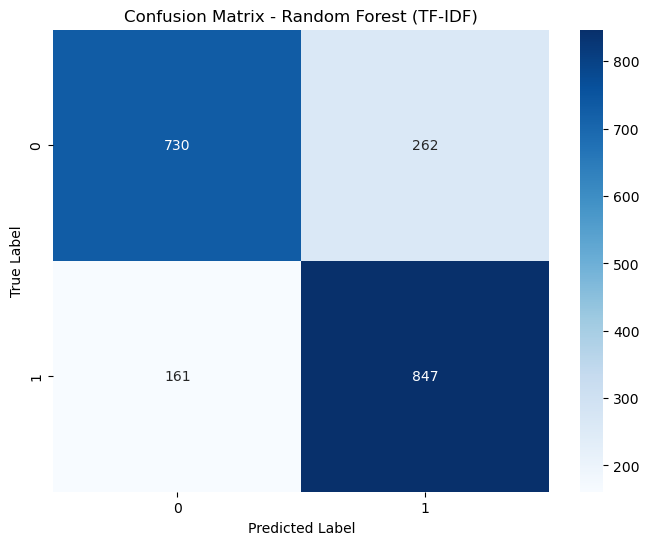

CPU times: total: 41.2 s
Wall time: 45.4 s


In [18]:
%%time
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=42)
# applying the model   
evaluate_model(rf, X_tfidf_train, X_tfidf_test, 
               y_train_tfidf, y_test_tfidf, 
               "Random Forest", "TF-IDF")

In [21]:
def print_sample_predictions(model, X_test, y_test, original_texts, n_samples):
    # get predictions
    y_pred = model.predict(X_test)
    
    # get original texts (assuming they're in the same order as X_test)
    sample_indices = np.random.choice(len(y_test), n_samples, replace=False)
    
    print("\nSample Predictions vs Actual Labels:")
    print("-" * 80)
    
    for idx in sample_indices:
        print(f"Text: {original_texts[idx]}")
        print(f"Predicted: {'Positive' if y_pred[idx] == 1 else 'Negative'}")
        print(f"Actual: {'Positive' if y_test.iloc[idx] == 1 else 'Negative'}")
        print("-" * 80)

In [25]:
print_sample_predictions(rf, X_tfidf_test, y_test_tfidf, sampled_data['content'], n_samples=5)


Sample Predictions vs Actual Labels:
--------------------------------------------------------------------------------
Text: no one should play a moba
Predicted: Positive
Actual: Positive
--------------------------------------------------------------------------------
Text: Meh
Predicted: Positive
Actual: Positive
--------------------------------------------------------------------------------
Text: The maker of this game should kill his self:)
Predicted: Negative
Actual: Positive
--------------------------------------------------------------------------------
Text: game kontol forced closed terus dari dulu sampek sekarang tetep ada ajaa masalahnya
Predicted: Positive
Actual: Negative
--------------------------------------------------------------------------------
Text: Downvoting for Valve's continued neglect in failing to stop bots and cheating.
Predicted: Positive
Actual: Positive
--------------------------------------------------------------------------------
